In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
from PIL import Image
from functools import partial

from jutils import ims_to_grid
from jutils.nn import AutoencoderKL
from jutils import tensor2im, freeze

while not os.path.exists('ldm'):
    %cd ..
assert os.path.exists('ldm')

from ldm.flow import Flow
from ldm.models.transformer.dit import DiT_models

DEV = 'cuda:0'

/export/home/ru59wap/miniforge3/envs/jenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
net = DiT_models["DiT-XL/2"](
    input_size=32,
    num_classes=1000,
    learn_sigma=True,               # we "learn sigma" but never use it in SiT/DiT
    load_from_ckpt='checkpoints/SiT-XL-2-256x256.pt'
).to(DEV)
freeze(net)

print(f"Params: {sum([p.numel() for p in net.parameters()]):,}")

[DiT] Class-conditional (1000 classes + unconditional)
[DiT] Loading weights from checkpoints/SiT-XL-2-256x256.pt
Params: 675,129,632


In [3]:
flow = Flow(schedule="linear")

vae = AutoencoderKL(ckpt_path="checkpoints/sd_ae.ckpt").to(DEV)

[AutoencoderKL] Loading checkpoint from checkpoints/sd_ae.ckpt


## Sampling

100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


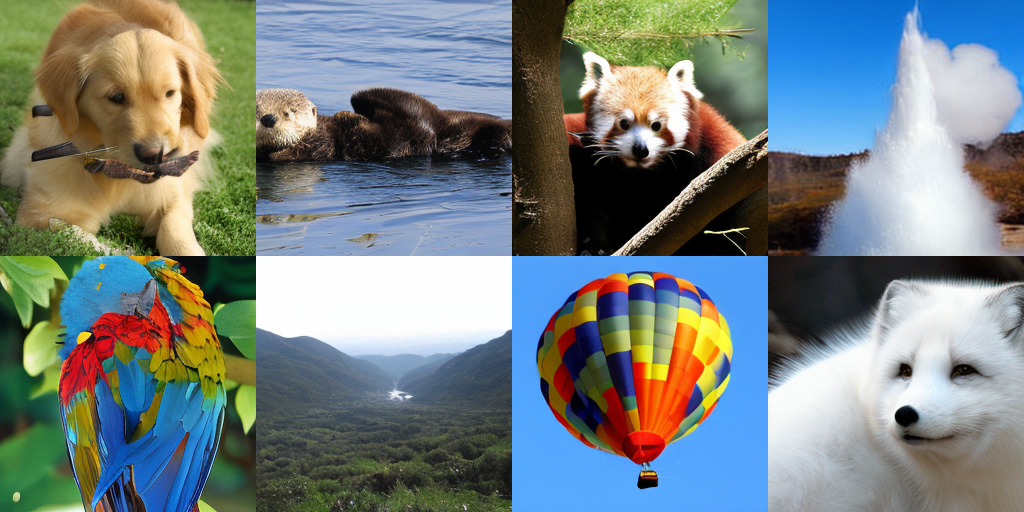

In [4]:
num_steps = 50
cfg_scale = 4.0

class_labels = [207, 360, 387, 974, 88, 979, 417, 279]

n = len(class_labels)
torch.manual_seed(2024)
noise = torch.randn(n, 4, 32, 32, device=DEV)
y = torch.tensor(class_labels, device=DEV)
y_null = torch.tensor([1000] * n, device=DEV)

# sample
with torch.no_grad(), torch.autocast("cuda"):
    z = flow.generate(
        model=net, x=noise,
        num_steps=num_steps,
        y=y,
        cfg_scale=cfg_scale,
        cond_key="y",
        uc_cond=y_null
    )
    x = vae.decode(z)

ims = tensor2im(x)
ims = ims_to_grid(ims, split=2, channel_last=True)
Image.fromarray(ims).show()

## Sampling Function

In [5]:
from ldm.flow import forward_with_cfg
# sampler functions
from ldm.flow_integrators import euler, rk4                 # ODE
from ldm.flow_integrators import euler_maruyama, heun       # SDE

100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


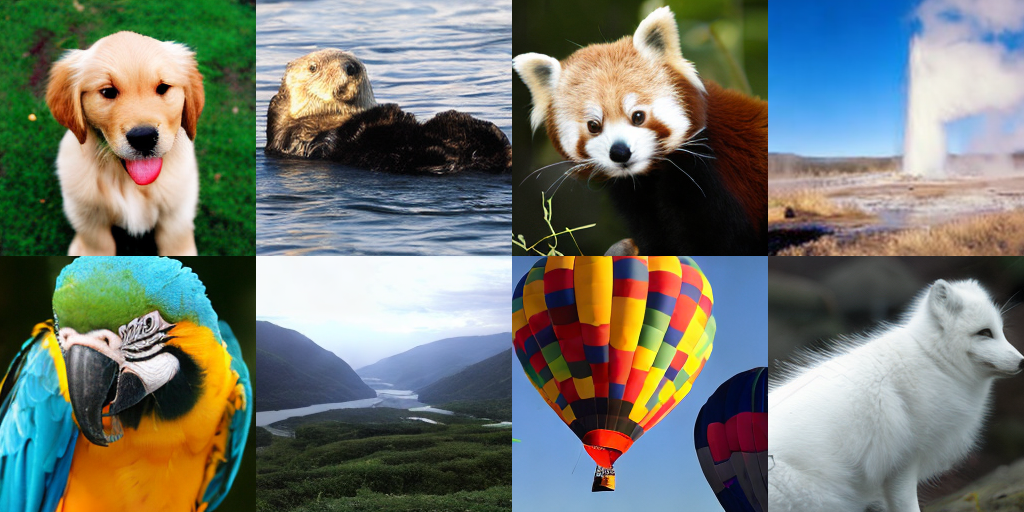

In [6]:
num_steps = 50
cfg_scale = 4.0
sample_fn = heun

class_labels = [207, 360, 387, 974, 88, 979, 417, 279]

n = len(class_labels)
torch.manual_seed(2024)
noise = torch.randn(n, 4, 32, 32, device=DEV)
y = torch.tensor(class_labels, device=DEV)
y_null = torch.tensor([1000] * n, device=DEV)
timesteps = torch.linspace(0, 1, num_steps + 1)

# define kwargs
fn = partial(forward_with_cfg, model=net)
sde_kwargs = dict(schedule=flow.schedule, diffusion_form="decreasing", diffusion_norm=2.0, last_step="euler")

# sample
with torch.no_grad(), torch.autocast("cuda"):
    
    if sample_fn == euler or sample_fn == rk4:      # ODE
        z = sample_fn(fn, noise, timesteps, progress=True, y=y, cfg_scale=cfg_scale, uc_cond=y_null, cond_key="y")
    else:                                           # SDE
        z = sample_fn(fn, noise, timesteps, progress=True, y=y, cfg_scale=cfg_scale, uc_cond=y_null, cond_key="y", **sde_kwargs)

    x = vae.decode(z)

ims = tensor2im(x)
ims = ims_to_grid(ims, split=2, channel_last=True)
Image.fromarray(ims).show()

---